### This guidebook provides a framework for analyzing JUUL employee emails using time series techniques. The goal is to understand communication patterns and communication dynamics over time.

#### Import the required libraries


In [1]:
import re
import polars as pl
import plotly.graph_objects as go
import plotly.express as px

#### Read the document metadata parquet file generated using API wrapper in JUUL_Document_Retrieval.ipynb

In [2]:
df = pl.read_parquet('juul_documents_metadata.parquet') # modify the filename as required
df.shape

(2045, 25)

#### Step 1: Data Preparation

Modify the dataframe to keep columns of interest and filter for emails

In [3]:
# Modify the dataframe to keep the following columns id, 'title', 'author','documentdate', 'type', 'pages', 'topic' which are of interest for the analysis.
df = df.filter(pl.col('type').list.contains('email')).select('id', 'title', 'author','documentdate', 'type', 'pages', 'topic')
df.shape

(2045, 7)

Example of what the modified dataframe should look like

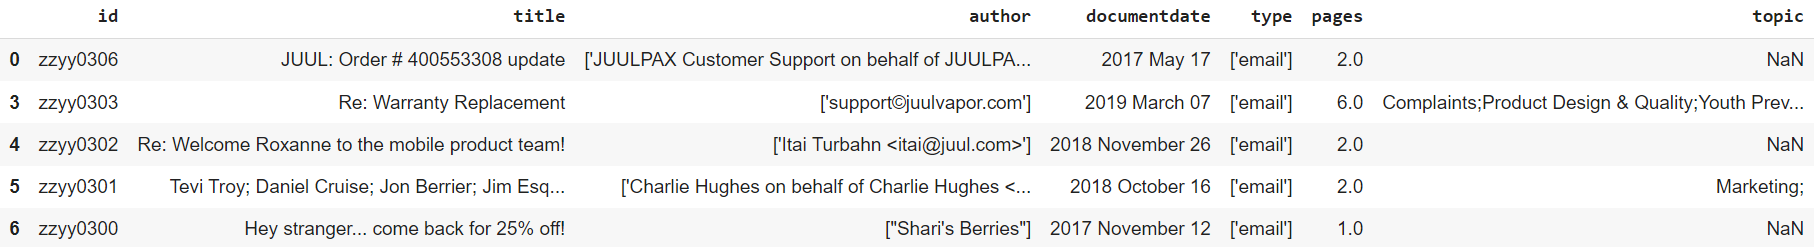

Check for null values in author, document date and topic column. Remove records with null values if required

In [4]:
df = df.drop_nulls(pl.selectors.by_name('author', 'documentdate', 'topic'))
df.shape

(585, 7)

Assign the broad topic for each email record

In [5]:
df = df.with_columns(pl.col("topic").str.split(';').list.get(0).alias("assigned_topic"))
df.shape

(585, 8)

In [6]:
set(*df.select("assigned_topic").to_dict().values())

{'Brand Protection',
 'Complaints',
 'Corporate Development',
 'Flavors',
 'Government & Public Affairs',
 'Health & Safety',
 'Marketing',
 'Marketing\\Online Advertising',
 'Product Design & Quality'}

Convert the date to correct datetime format

In [7]:
df = df.with_columns(pl.col('documentdate').str.to_date(format='%Y %B %d')) # example documentdate: 2020 May 03
df.dtypes

[String, String, List(String), Date, List(String), Int64, String, String]

In [8]:
df

id,title,author,documentdate,type,pages,topic,assigned_topic
str,str,list[str],date,list[str],i64,str,str
"""ffpb0285""","""OOO - JUUL Launch Party! #Ligh…","[""Ashley Marand <ashley@pax.com>""]",2015-06-05,"[""email""]",1,"""Marketing""","""Marketing"""
"""ffxy0284""","""You are Invited!""","[""Kate Morgan <kate@ploom.com>""]",2015-05-13,"[""email""]",2,"""Marketing""","""Marketing"""
"""fgpb0285""","""OOO - JUUL Launch Party! #Ligh…","[""Ashley Marand <ashley@pax.com>""]",2015-06-03,"[""email""]",1,"""Marketing""","""Marketing"""
"""fhgj0296""","""Re: Today's Call 4.9.15""","[""Kate Morgan <kate@ploom.com>""]",2015-04-13,"[""email""]",4,"""Marketing""","""Marketing"""
"""fhjc0303""","""Re: Media Inquiry""","[""Ted Kwong <theodore.kwong@juul.com>""]",2019-02-18,"[""email""]",2,"""Marketing;""","""Marketing"""
…,…,…,…,…,…,…,…
"""zypn0287""","""Re: PAX at American Two Shot P…","[""Janjay Sherman <j@gritcreativegroup.com>""]",2015-07-23,"[""email""]",10,"""Marketing""","""Marketing"""
"""zzdm0299""","""Fwd: JUUL launch party, NY nex…","[""Kate Morgan on behalf of Kate Morgan <kate©pax.com>""]",2015-07-09,"[""email""]",1,"""Marketing;""","""Marketing"""
"""zzhy0284""","""Re: You are Invited!""","[""Aliza Soriano <aliza@insidehook.com>""]",2015-05-13,"[""email""]",2,"""Marketing""","""Marketing"""


In [9]:
# Filter the DataFrame to include only rows with 'juul', 'pax', or 'ploom' in the author column
l = ['juul', 'pax', 'ploom', 'juullabs']
filtered_df = df.filter(pl.col('author').list.eval(pl.element().str.contains_any(l)).list.any())
filtered_df.shape

(405, 8)

The filtered_df should look like this
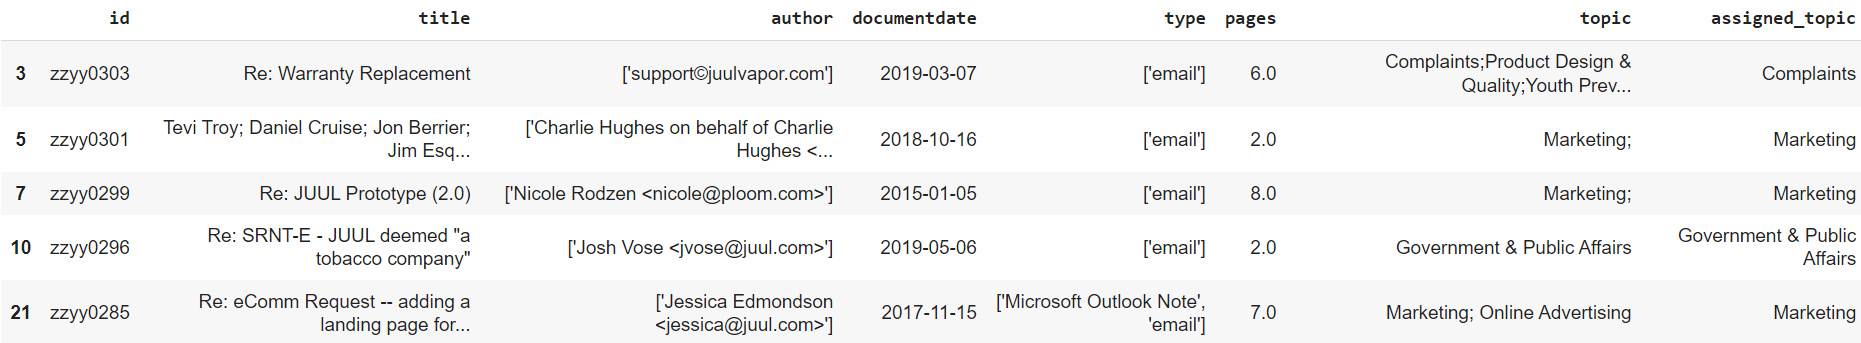

In [10]:
filtered_df.head()

id,title,author,documentdate,type,pages,topic,assigned_topic
str,str,list[str],date,list[str],i64,str,str
"""ffpb0285""","""OOO - JUUL Launch Party! #Ligh…","[""Ashley Marand <ashley@pax.com>""]",2015-06-05,"[""email""]",1,"""Marketing""","""Marketing"""
"""ffxy0284""","""You are Invited!""","[""Kate Morgan <kate@ploom.com>""]",2015-05-13,"[""email""]",2,"""Marketing""","""Marketing"""
"""fgpb0285""","""OOO - JUUL Launch Party! #Ligh…","[""Ashley Marand <ashley@pax.com>""]",2015-06-03,"[""email""]",1,"""Marketing""","""Marketing"""
"""fhgj0296""","""Re: Today's Call 4.9.15""","[""Kate Morgan <kate@ploom.com>""]",2015-04-13,"[""email""]",4,"""Marketing""","""Marketing"""
"""fhjc0303""","""Re: Media Inquiry""","[""Ted Kwong <theodore.kwong@juul.com>""]",2019-02-18,"[""email""]",2,"""Marketing;""","""Marketing"""


#### Time series analysis



Visualize the graph for change in email volume for broad topics across the years

In [11]:
import itertools
# Group by year and overall topic, visualize the graph - email records
filtered_df = filtered_df.with_columns(pl.col("documentdate").dt.year().alias("year"), pl.col("documentdate").dt.month().alias("month"))
yearly_topic_counts = filtered_df.group_by(['year', 'assigned_topic']).len(name='document_count').sort('year')
years = filtered_df['year'].unique()
assigned_topics = filtered_df['assigned_topic'].unique()
combinations = list(itertools.product(years, assigned_topics))

l = []
for year, assigned_topic in combinations:
    l.append({"year": year, "assigned_topic": assigned_topic})
temp = pl.DataFrame(l, schema_overrides={"year": pl.Int32})
cross = temp.join(yearly_topic_counts, on=["year","assigned_topic"], how="left")
yearly_topic_counts = cross.fill_null(0)
print(yearly_topic_counts)

shape: (54, 3)
┌──────┬──────────────────────────────┬────────────────┐
│ year ┆ assigned_topic               ┆ document_count │
│ ---  ┆ ---                          ┆ ---            │
│ i32  ┆ str                          ┆ u32            │
╞══════╪══════════════════════════════╪════════════════╡
│ 2014 ┆ Marketing                    ┆ 3              │
│ 2014 ┆ Health & Safety              ┆ 0              │
│ 2014 ┆ Product Design & Quality     ┆ 0              │
│ 2014 ┆ Corporate Development        ┆ 0              │
│ 2014 ┆ Brand Protection             ┆ 0              │
│ …    ┆ …                            ┆ …              │
│ 2019 ┆ Brand Protection             ┆ 1              │
│ 2019 ┆ Complaints                   ┆ 0              │
│ 2019 ┆ Marketing\Online Advertising ┆ 0              │
│ 2019 ┆ Government & Public Affairs  ┆ 3              │
│ 2019 ┆ Flavors                      ┆ 0              │
└──────┴──────────────────────────────┴────────────────┘


In [12]:
fig = go.Figure()

# Add a trace for each topic
for topic in yearly_topic_counts['assigned_topic'].unique():
    topic_data = yearly_topic_counts.filter(pl.col('assigned_topic') == topic)
    fig.add_trace(go.Scatter(x=topic_data['year'].cast(str), y=topic_data['document_count'],
                             mode='lines', name=topic))

# Layout - titles
fig.update_layout(
    title='Email Counts by Year and Broad Topic',
    xaxis_title='Year',
    yaxis_title='Number of Documents',
    legend_title='Broad Topic')

fig.show()

Visualize the number of email records by year, overall topic, and detailed topic, with an interactive dropdown for filtering.

In [14]:
# Group by year, assigned_topic, and topic, then count the documents
yearly_topic_counts = filtered_df.group_by(['year', 'assigned_topic', 'topic']).len(name='document_count').sort('year')

# Create the figure
fig = go.Figure()

# Add a trace for each unique topic
for topic in yearly_topic_counts['topic'].unique():
    topic_data = yearly_topic_counts.filter(pl.col('topic').eq(topic))
    fig.add_trace(go.Scatter(x=topic_data['year'], y=topic_data['document_count'],
                             mode='lines', name=topic))

# Get unique assigned topics for the dropdown filter
assigned_topics = yearly_topic_counts['assigned_topic'].unique()

# Create dropdown buttons
dropdown_buttons = [{'label': 'All Topics', 'method': 'update', 'args': [{'visible': [True] * len(fig.data)}, {'title': 'Document Counts by Year and Topic'}]}]

for assigned_topic in assigned_topics:
    visibility = [(trace.name in yearly_topic_counts.filter(pl.col('assigned_topic').eq(assigned_topic))['topic']) for trace in fig.data]
    dropdown_buttons.append({
        'label': assigned_topic,
        'method': 'update',
        'args': [{'visible': visibility},
                 {'title': f'Document Counts by Year for {assigned_topic}'}]})

# Layout - titles and dropdown
fig.update_layout(
    title='Email Counts by Year and Topic',
    xaxis_title='Year',
    yaxis_title='Number of Documents',
    legend_title='Topic',
    updatemenus=[{'buttons': dropdown_buttons,
                  'direction': 'down',
                  'showactive': True,}])

# Show the plot
fig.show()


Visualize the graph for change in email volume for broad topics across month and year for more granular analysis

In [17]:


# Group by month and overall topic, visualize the graph - email records
monthly_topic_counts = filtered_df.group_by(['month', 'assigned_topic']).len(name='document_count').sort('month')

fig = go.Figure()

# Add a trace for each topic
for topic in monthly_topic_counts['assigned_topic'].unique():
    topic_data = monthly_topic_counts.filter(pl.col('assigned_topic').eq(topic))
    fig.add_trace(go.Scatter(x=topic_data['month'], y=topic_data['document_count'],
                             mode='lines', name=topic))

# Layout - titles
fig.update_layout(
    title='Email Counts by Month and Broad Topic',
    xaxis_title='Month',
    yaxis_title='Number of Documents',
    legend_title='Broad Topic')

fig.show()

Visualize the number of email records by month, overall topic, and detailed topic, with an interactive dropdown for filtering.

In [19]:
monthly_topic_counts = filtered_df.group_by(['month', 'assigned_topic', 'topic']).len(name='document_count').sort('month')

fig = go.Figure()

# Add a trace for each detailed topic
for topic in monthly_topic_counts['topic'].unique():
    topic_data = monthly_topic_counts.filter(pl.col('topic').eq(topic))
    fig.add_trace(go.Scatter(x=topic_data['month'], y=topic_data['document_count'],
                             mode='lines', name=topic))

# Get unique assigned topics for the dropdown filter
assigned_topics = monthly_topic_counts['assigned_topic'].unique()

# Create dropdown buttons
dropdown_buttons = [{'label': 'All Topics', 'method': 'update', 'args': [{'visible': [True] * len(fig.data)}, {'title': 'Document Counts by Month and Topic'}]}]

for assigned_topic in assigned_topics:
    visibility = [(trace.name in monthly_topic_counts.filter(pl.col('assigned_topic').eq(assigned_topic))['topic']) for trace in fig.data]
    dropdown_buttons.append({
        'label': assigned_topic,
        'method': 'update',
        'args': [{'visible': visibility},
                 {'title': f'Email Counts by Month for {assigned_topic}'}]})

# Layout - titles and dropdown
fig.update_layout(
    title='Email Counts by Month and Topic',
    xaxis_title='Month',
    yaxis_title='Number of Documents',
    legend_title='Topic',
    updatemenus=[{'buttons': dropdown_buttons,
                  'direction': 'down',
                  'showactive': True,}])

# Show the plot
fig.show()


### Time series analysis by author

Extract email ids of employees

In [31]:

email_regexp = re.compile(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b')
def extract_email(email_list):
    res = email_regexp.findall(email_list[0])
    return res[0] if res else None
filtered_df = filtered_df.with_columns(pl.col('author').map_elements(extract_email, return_dtype=str).alias('author_email'))

In [32]:
# run to check whether the name and email id have been extracted correctly
filtered_df.select('author', 'author_email')

author,author_email
list[str],str
"[""Ashley Marand <ashley@pax.com>""]","""ashley@pax.com"""
"[""Kate Morgan <kate@ploom.com>""]","""kate@ploom.com"""
"[""Ashley Marand <ashley@pax.com>""]","""ashley@pax.com"""
"[""Kate Morgan <kate@ploom.com>""]","""kate@ploom.com"""
"[""Ted Kwong <theodore.kwong@juul.com>""]","""theodore.kwong@juul.com"""
…,…
"[""Christopher Karimian <christopher.karimian@juul.com>""]","""christopher.karimian@juul.com"""
"[""Spencer Pederson <spencer@pax.com>""]","""spencer@pax.com"""
"[""Ashley Marand <ashley@pax.com>""]","""ashley@pax.com"""


In [33]:
# run to check number of unique authors to select the top X number of authors to visualize
unique_author_emails = filtered_df['author_email'].unique()
print(f"Number of unique author emails: {len(unique_author_emails)}")


Number of unique author emails: 54


In [34]:
filtered_df.columns

['id',
 'title',
 'author',
 'documentdate',
 'type',
 'pages',
 'topic',
 'assigned_topic',
 'year',
 'month',
 'author_email']

Visualize email records by year and author for top X number

In [38]:
# Group by year and author, visualize the graph - email records
author_total_counts = filtered_df.group_by('author_email').len(name='total_count').sort('total_count')
top_150_authors = author_total_counts.head(150)['author_email'] # modify as required
filtered_email_pdf = filtered_df.filter(pl.col('author_email').is_in(top_150_authors)) # modify as required
yearly_topic_counts = filtered_email_pdf.group_by(['year', 'author_email']).len(name='document_count').sort('year')

fig = go.Figure()

# Add a trace for each author
for author in yearly_topic_counts['author_email'].unique():
    author_data = yearly_topic_counts.filter(pl.col('author_email').eq(author))
    fig.add_trace(go.Scatter(x=author_data['year'], y=author_data['document_count'],
                             mode='lines', name=author, visible='legendonly'))

# Add dropdown filter
dropdown_buttons = [
    {'label': 'All Authors', 'method': 'update', 'args': [{'visible': [True]*len(fig.data)}, {'title': 'Document Counts by Year and Top 150 Authors'}]}]

for i, author in enumerate(yearly_topic_counts['author_email'].unique()):
    visible = [False]*len(fig.data)
    visible[i] = True
    dropdown_buttons.append({'label': author, 'method': 'update', 'args': [{'visible': visible}, {'title': f'Document Counts by Year for {author}'}]})

fig.update_layout(
    updatemenus=[{
        'buttons': dropdown_buttons,
        'direction': 'down',
        'showactive': True
    }],
    title='Email Counts by Year and Top 150 Authors',
    xaxis_title='Year',
    yaxis_title='Number of Documents',
    legend_title='Author')

fig.show()

Visualize email records by year, topic and author for all authors

In [40]:
# Group by year, author, and topic
yearly_topic_counts = filtered_email_pdf.group_by(['year', 'author_email', 'assigned_topic']).len(name='document_count').sort('year')

fig = go.Figure()

# Add traces for each author and topic
for author in yearly_topic_counts['author_email'].unique():
    author_data = yearly_topic_counts.filter(pl.col('author_email').eq(author))
    for topic in author_data['assigned_topic'].unique():
        topic_data = author_data.filter(pl.col('assigned_topic').eq(topic))
        fig.add_trace(go.Scatter(x=topic_data['year'], y=topic_data['document_count'],
                                 mode='lines', name=f'{author} - {topic}', visible=False))

# Make the first author's traces visible by default
initial_author = yearly_topic_counts['author_email'].unique()[0]
for i, trace in enumerate(fig.data):
    if initial_author in trace.name:
        fig.data[i].visible = True

# Create dropdown menu
dropdown_buttons = []
for author in yearly_topic_counts['author_email'].unique():
    visible = [author in trace.name for trace in fig.data]
    button = dict(label=author,
                  method="update",
                  args=[{"visible": visible},
                        {"title": f"Document Counts by Year for {author}"}])
    dropdown_buttons.append(button)

# Update layout with dropdown
fig.update_layout(
    title=f'Document Counts by Year for {initial_author}',
    xaxis_title='Year',
    yaxis_title='Number of Documents',
    legend_title='Topic',
    updatemenus=[{
        "buttons": dropdown_buttons,
        "direction": "down",
        "showactive": True,}])

fig.show()